In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, SimpleRNN, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [2]:
# ---- PARAMETERS ----
FS            = 50        # sampling freq (Hz)
WINDOW_SZ     = 50        # window size (samples ≈1s)
EPOCHS        = 25
BATCH_SIZE    = 64
PLOT_DURATION = 10        # seconds to plot

# Filepaths for each walking speed
DATA_FILES = {
    "fastest": "Project/imu_data_fastest_speed.csv",
    "medium":  "Project/imu_data_medium_speed.csv",
    "slowest": "Project/imu_data_slowest_speed.csv"
}

### Loading IMU Data

In [3]:
def load_imu_data(path):
    return pd.read_csv(path)

### Quaternion to Pitch Conversion

In [4]:
def quaternion_to_pitch(w, x, y, z):
    t2 = 2.0 * (w*y - x*z)
    t5 = w*w - x*x - y*y + z*z
    return np.degrees(np.arctan2(t2, t5))

### Visualize Data

In [5]:
def plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix):
    mask = times <= PLOT_DURATION
    mask2 = times2 <= PLOT_DURATION
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].plot(times[mask], df['pitch1_sm'][mask], label='Thigh Pitch (sm)')
    ax[0].plot(times[mask], df['pitch2_sm'][mask], label='Shin Pitch (sm)')
    for t in times[minima_idx]:
        if t <= PLOT_DURATION:
            ax[0].axvline(t, color='k', ls='--', alpha=0.6)
    ax[0].set_title(f"Pitch & Toe-offs (0-{PLOT_DURATION}s)")
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Pitch (°)')
    ax[0].legend()

    ax[1].plot(times[mask], df['omega1'][mask], label='Thigh ω (°/s)')
    ax[1].plot(times[mask], df['omega2'][mask], label='Shin ω (°/s)')
    ax[1].set_title(f"Angular Velocity (0-{PLOT_DURATION}s)")
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular velocity (°/s)')
    ax[1].legend()

    ax[2].plot(times2[mask2], df2['t_toeoff'][mask2])
    ax[2].set_title(f"Time-to-Toe-off vs Time (0-{PLOT_DURATION}s)")
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Seconds to Next Toe-off')

    ax[3].hist(df2['t_toeoff'], bins=50)
    ax[3].set_title(f"Time-to-Toe-off Distribution")
    ax[3].set_xlabel('Time to Toe-off (s)')
    ax[3].set_ylabel('Count')

    fig.suptitle(f"{title_prefix.capitalize()}")

    return fig

### Detect Toe-offs

In [6]:
pitch_plots = {}

def detect_and_plot_toeoffs(df, fs=FS, title_prefix=""):

    # compute raw & smoothed pitch
    df['pitch1'] = quaternion_to_pitch(df.QuatW,  df.QuatX,  df.QuatY,  df.QuatZ)
    df['pitch2'] = quaternion_to_pitch(df.QuatW2, df.QuatX2, df.QuatY2, df.QuatZ2)
    for c in ['pitch1','pitch2']:
        df[f'{c}_sm'] = (df[c]
                         .rolling(window=5, center=True)
                         .mean()
                         .fillna(method='bfill')
                         .fillna(method='ffill'))
    # compute angular velocities ω
    df['omega1'] = df['pitch1_sm'].diff().fillna(0) * fs
    df['omega2'] = df['pitch2_sm'].diff().fillna(0) * fs

    # time vector
    N     = len(df)
    times = np.arange(N) / fs

    # detect thigh-minima toe-offs AND only those below -100°
    minima_idx, _ = find_peaks(-df['pitch1_sm'].values, distance=int(0.3*fs))
    # filter to pitch1_sm[minima] < -100
    valid_minima = [i for i in minima_idx if df['pitch1_sm'].iloc[i] < -110]
    if len(valid_minima) < 2:
        raise RuntimeError(f"Too few thigh minima <-100° in {title_prefix}")
    minima_idx = np.array(valid_minima)

    # label time-to-toe-off
    next_toe = np.searchsorted(minima_idx, np.arange(N), side='right')
    valid    = next_toe < len(minima_idx)
    df2      = df.iloc[valid].reset_index(drop=True)
    times2   = times[valid]
    thigh_times = times[minima_idx]
    df2['t_toeoff'] = thigh_times[next_toe[valid]] - times2

    fig = plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix)

    pitch_plots[title_prefix] = fig

    return df2

### Making Dataset

In [7]:
def make_dataset_pca(df2, n_components):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ','AccX','AccY','AccZ','GyroX','GyroY','GyroZ',
                    'QuatW2','QuatX2','QuatY2','QuatZ2','AccX2','AccY2','AccZ2','GyroX2','GyroY2','GyroZ2']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    pca = PCA(whiten=True, n_components = n_components)
    X = pca.fit_transform(X.reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, n_components)

    return X, y

def make_dataset_thigh(df2):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ','AccX','AccY','AccZ','GyroX','GyroY','GyroZ']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    return X, y

def make_dataset_thigh_quats(df2):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    return X, y

def make_dataset_thigh_quats_accs(df2):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ','AccX','AccY','AccZ']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    return X, y

def make_dataset_thigh_quats_gyros(df2):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ','GyroX','GyroY','GyroZ']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    return X, y

### Machine Learning Approach

In [9]:
def RNN_make_model(input_shape, loss, metrics, optimizer):
    hidden_units_1 = 64
    hidden_units_2 = 32
    mlp_units = 16
    model = Sequential([
        SimpleRNN(hidden_units_1, return_sequences=True, input_shape=input_shape),
        SimpleRNN(hidden_units_2),
        Dense(mlp_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [10]:
def GRU_make_model(input_shape, loss, metrics, optimizer):
    hidden_units_1 = 64
    hidden_units_2 = 32
    mlp_units = 16
    model = Sequential([
        GRU(hidden_units_1, return_sequences=True, input_shape=input_shape),
        GRU(hidden_units_2),
        Dense(mlp_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

#### PCA

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db827429

Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.1205 - mae: 0.2600 - val_loss: 0.0758 - val_mae: 0.1945
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0679 - mae: 0.1807 - val_loss: 0.0652 - val_mae: 0.1814
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0649 - mae: 0.1735 - val_loss: 0.0612 - val_mae: 0.1752
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0600 - mae: 0.1654 - val_loss: 0.0624 - val_mae: 0.1672
Epoch 5/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0575 - mae: 0.1607 - val_loss: 0.0572 - val_mae: 0.1582
Epoch 6/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0575 - mae: 0.1606 - val_loss: 0.0553 - val_mae: 0.1551
Epoch 7/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0545 - mae: 0.1524 - val_loss: 0.0546 - val_mae: 0.1510
Epoch 8/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0521 - mae: 0.1490 - val_loss: 0.0549 - val_mae: 0.1560
Epoch 9/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db827429

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.1363 - mae: 0.2822 - val_loss: 0.0781 - val_mae: 0.1985
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0651 - mae: 0.1800 - val_loss: 0.0684 - val_mae: 0.1741
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0572 - mae: 0.1612 - val_loss: 0.0621 - val_mae: 0.1668
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0543 - mae: 0.1556 - val_loss: 0.0602 - val_mae: 0.1637
Epoch 5/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0514 - mae: 0.1502 - val_loss: 0.0632 - val_mae: 0.1558
Epoch 6/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0492 - mae: 0.1437 - val_loss: 0.0536 - val_mae: 0.1481
Epoch 7/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0447 - mae: 0.1369 - val_loss: 0.0552 - val_mae: 0.1511
Epoch 8/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0432 - mae: 0.1340 - val_loss: 0.0521 - val_mae: 0.1415
Epoch 9/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step -

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db827429

Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.1340 - mae: 0.2758 - val_loss: 0.0667 - val_mae: 0.1817
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0634 - mae: 0.1733 - val_loss: 0.0565 - val_mae: 0.1617
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0543 - mae: 0.1564 - val_loss: 0.0525 - val_mae: 0.1578
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0484 - mae: 0.1445 - val_loss: 0.0515 - val_mae: 0.1537
Epoch 5/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0446 - mae: 0.1388 - val_loss: 0.0493 - val_mae: 0.1454
Epoch 6/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0420 - mae: 0.1319 - val_loss: 0.0475 - val_mae: 0.1397
Epoch 7/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0412 - mae: 0.1295 - val_loss: 0.0433 - val_mae: 0.1342
Epoch 8/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0369 - mae: 0.1220 - val_loss: 0.0462 - val_mae: 0.1370
Epoch 9/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 

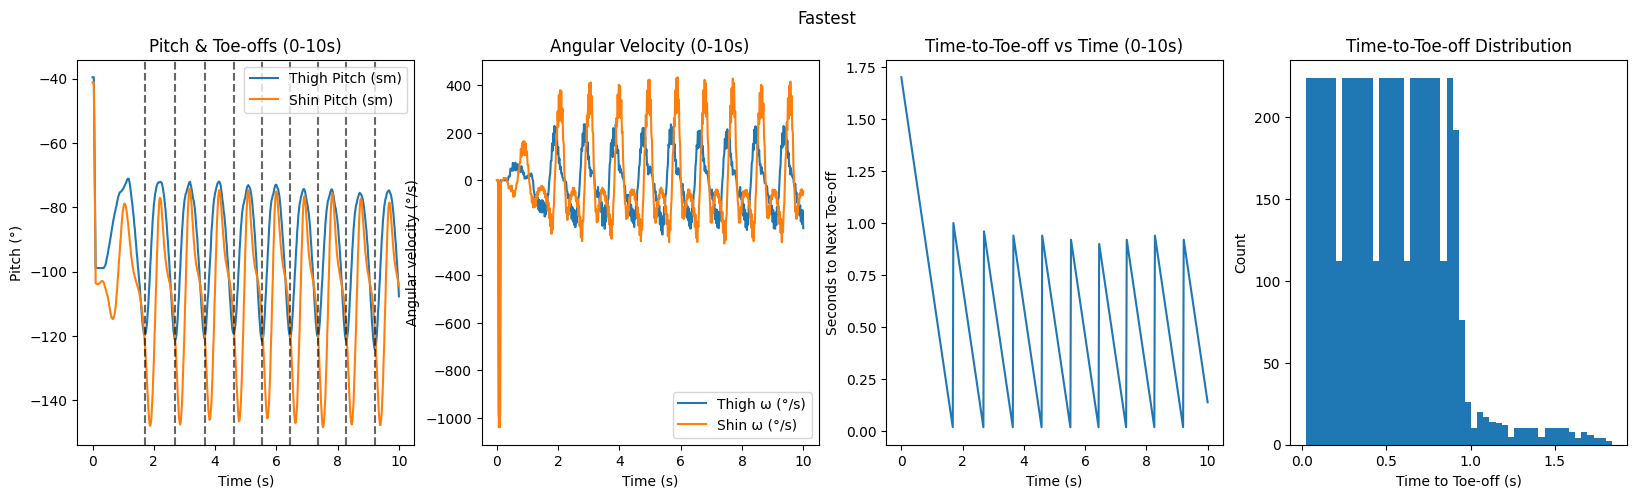

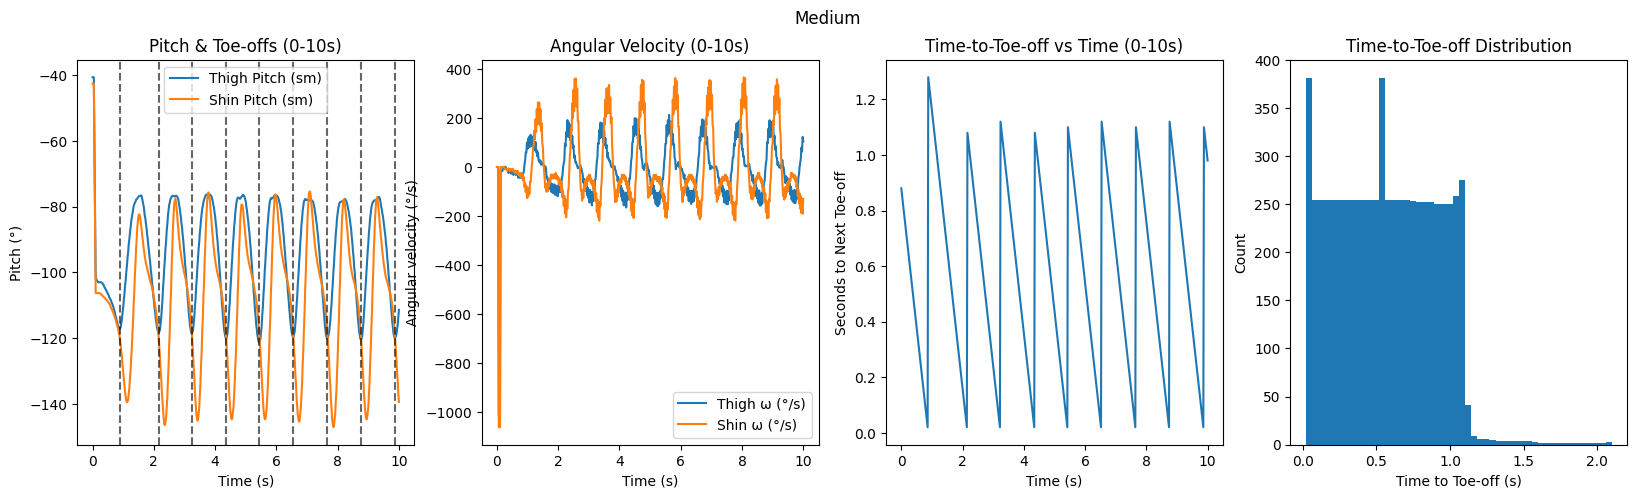

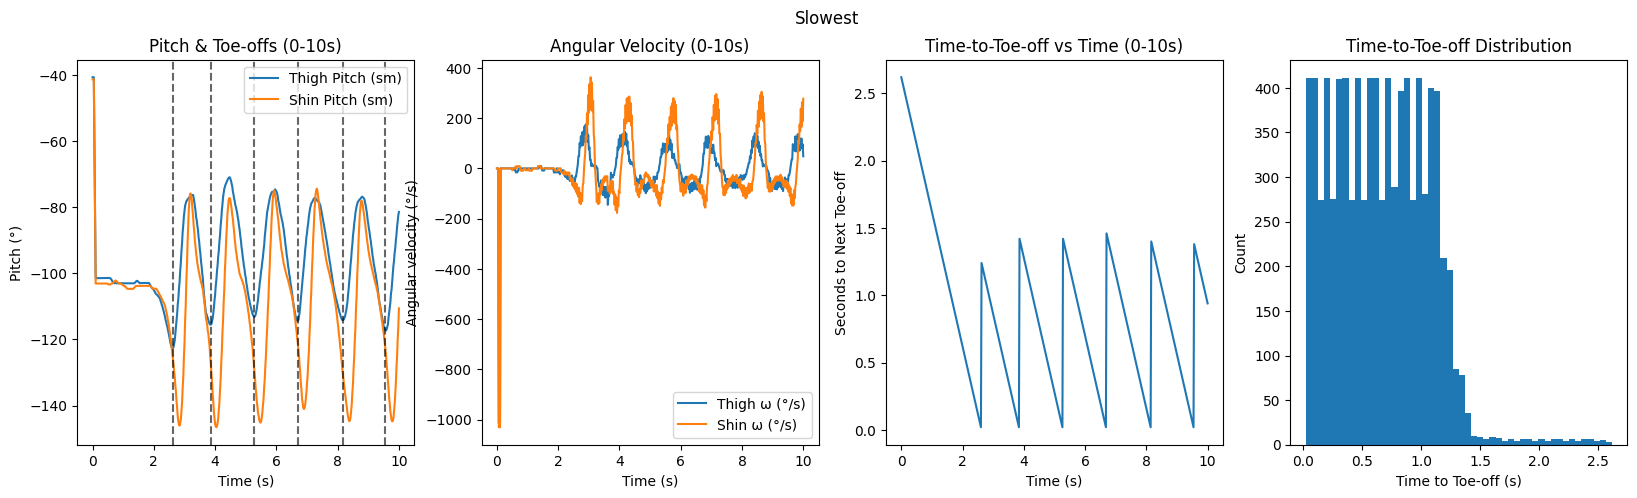

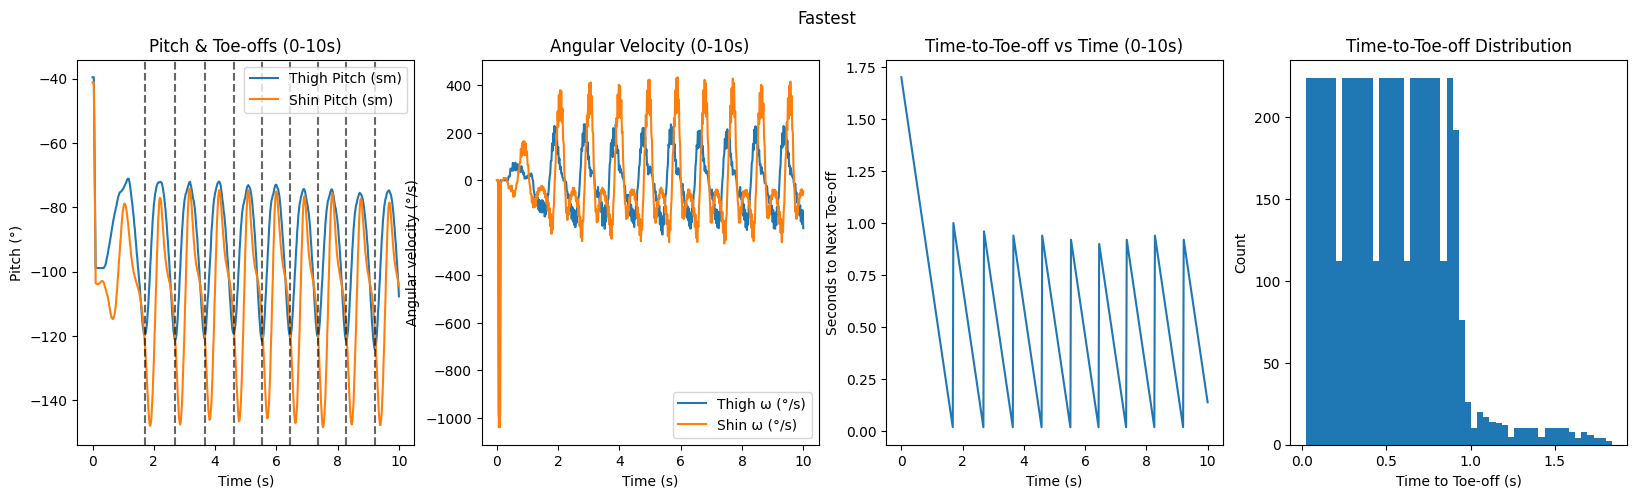

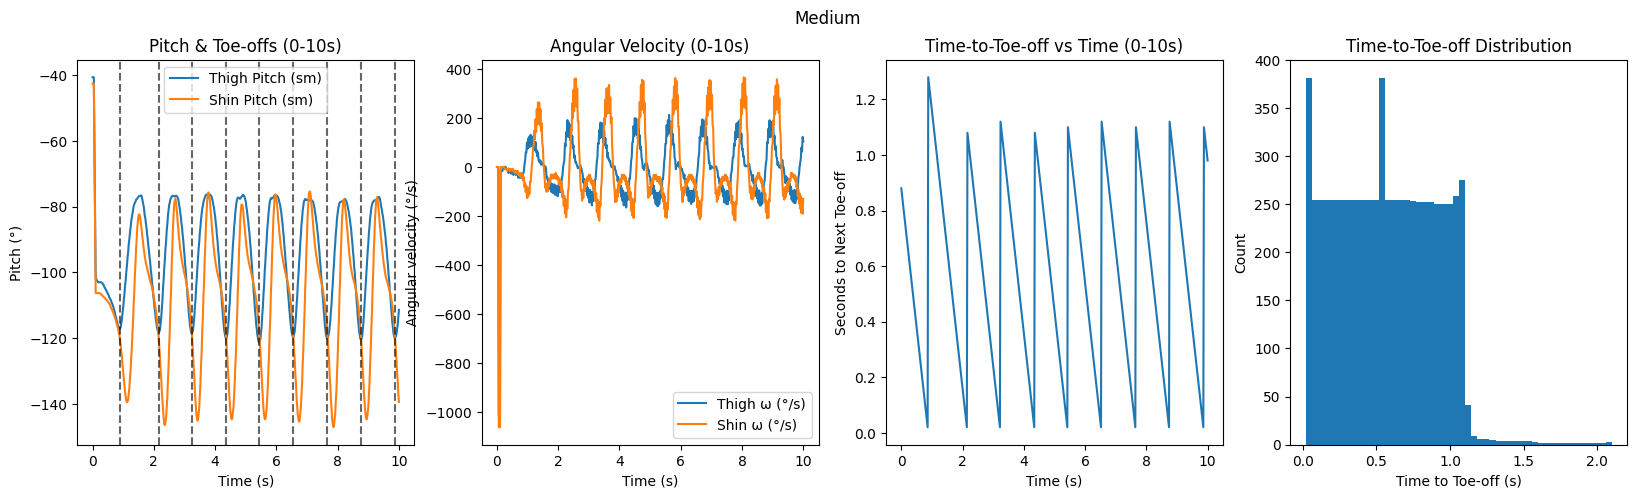

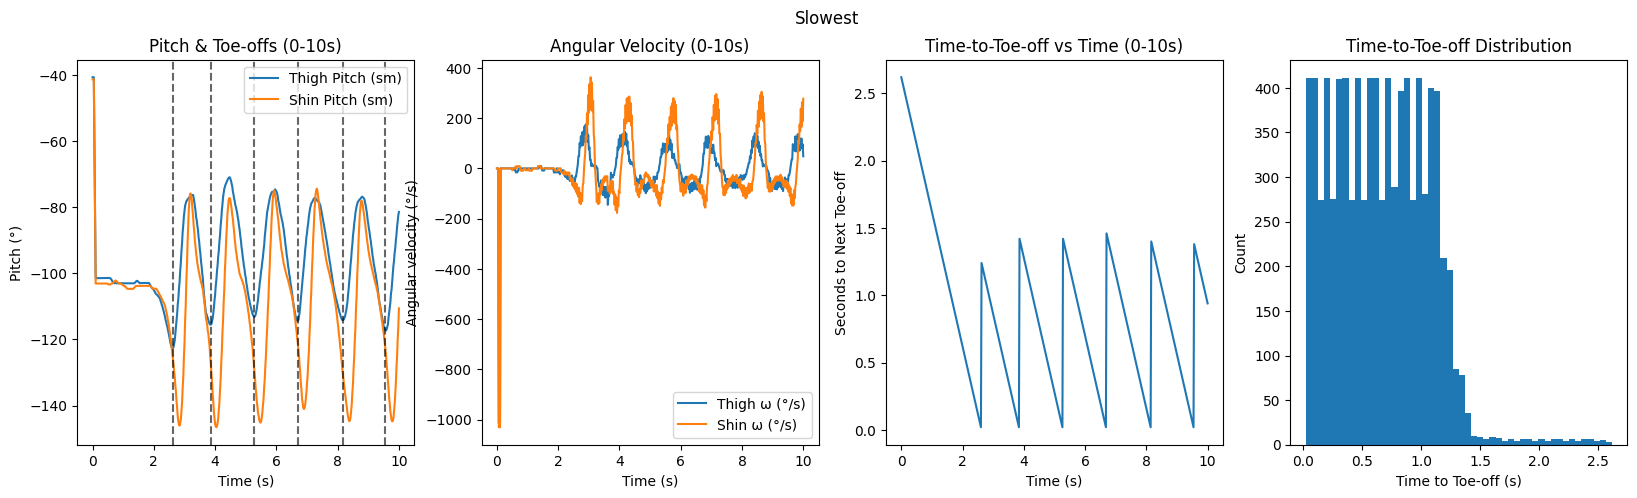

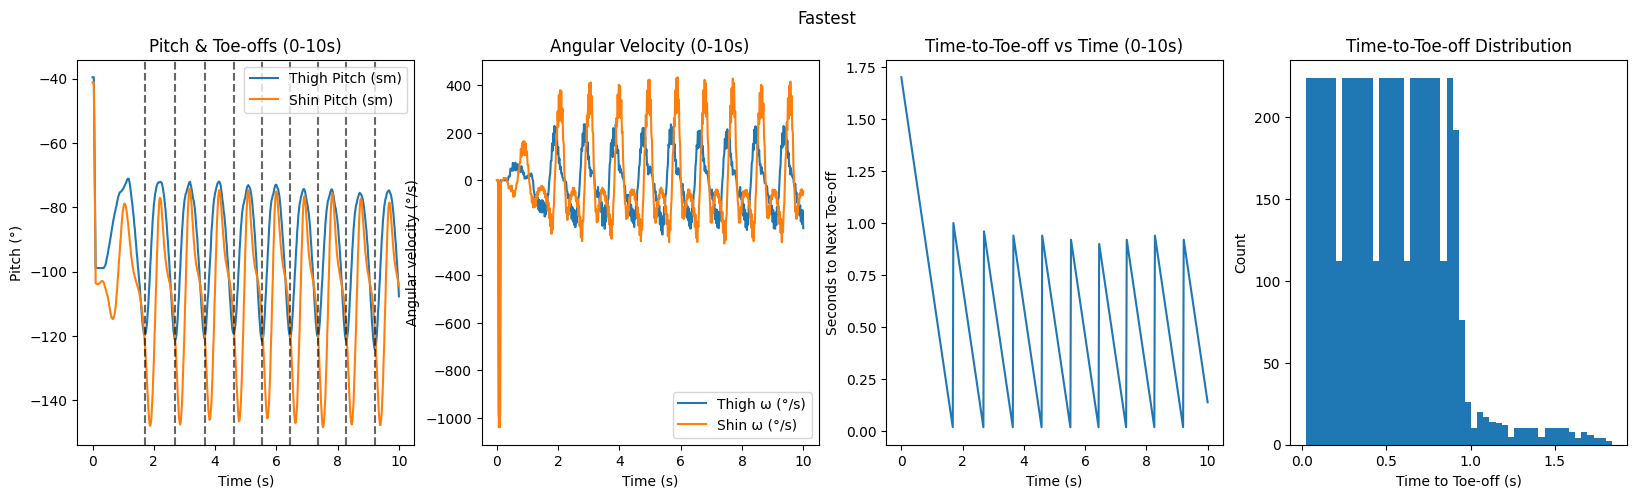

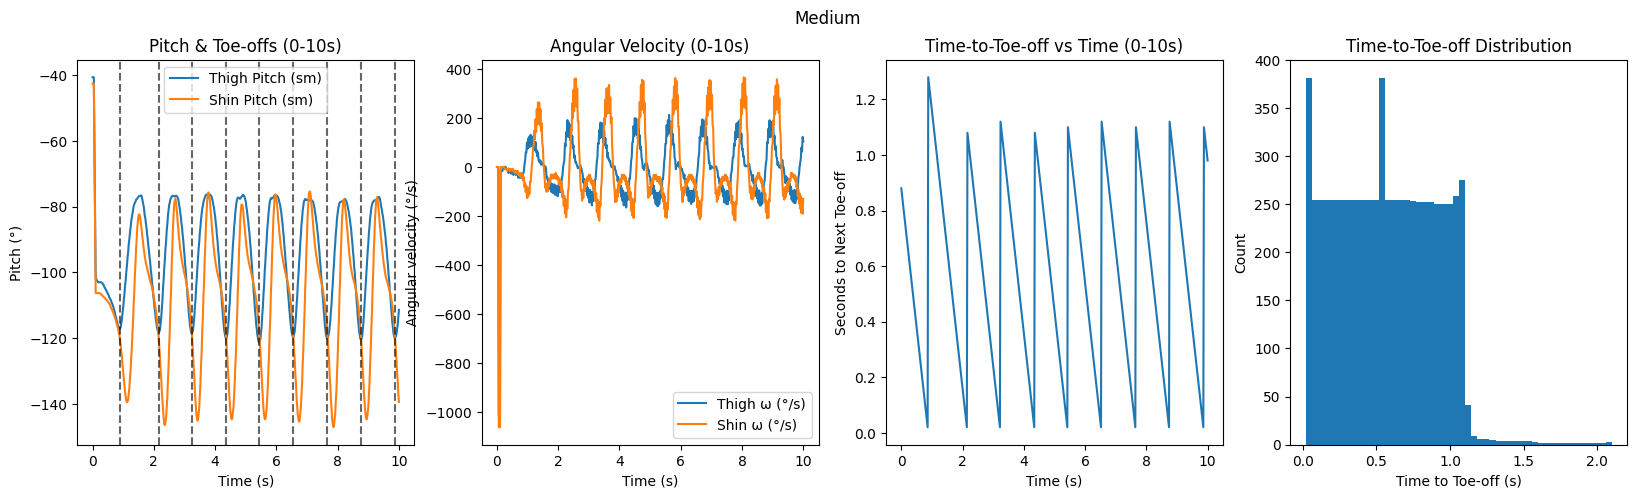

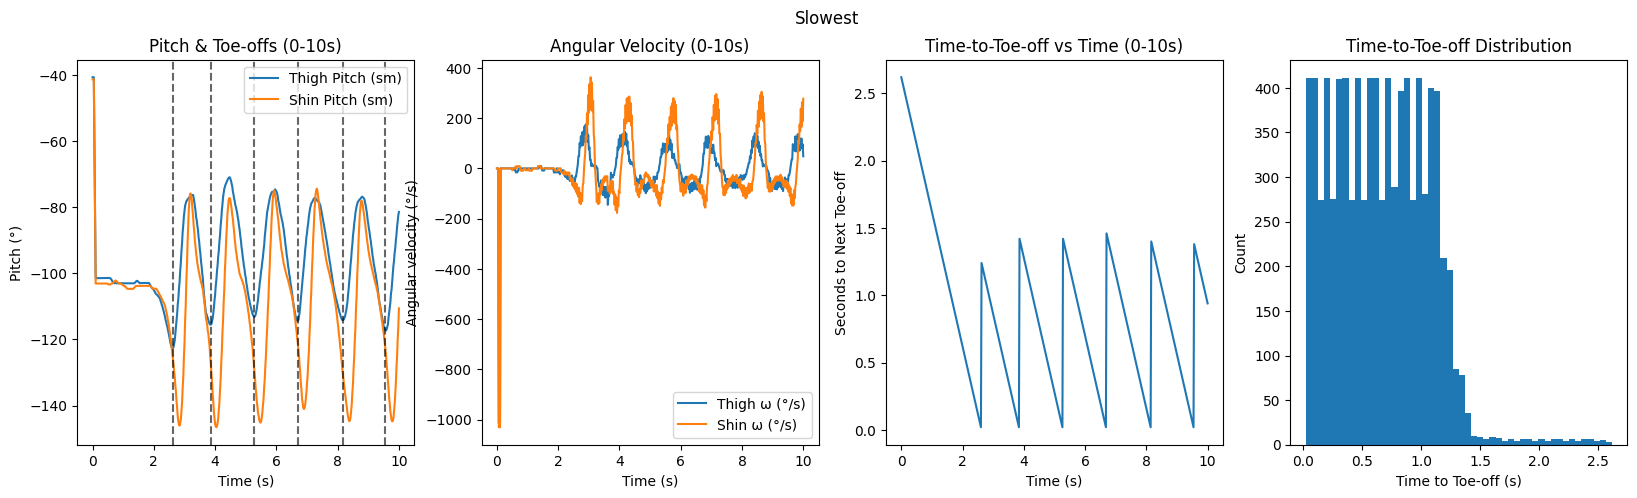

In [ ]:
for i in [5, 10, 15]:
    X_all_temp = []
    y_all_temp = []

    for name, path in DATA_FILES.items():
        df    = load_imu_data(path)
        df2   = detect_and_plot_toeoffs(df, title_prefix=name.capitalize())
        X, y  = make_dataset_pca(df2, i)

        X_all_temp.append(X)
        y_all_temp.append(y)

    X_all = np.concatenate([X_all_temp[i] for i in range(len(X_all_temp))], axis=0)
    y_all = np.concatenate([y_all_temp[i] for i in range(len(y_all_temp))], axis=0)

    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2)
    y_train_all = y_train_all.reshape(y_train_all.shape[0], -1)
    y_test_all = y_test_all.reshape(y_test_all.shape[0], -1)

    input_shape = (WINDOW_SZ, X_train_all.shape[2])

    RNN_datasets   = {}
    RNN_histories  = {}
    RNN_metrics    = {}

    GRU_datasets   = {}
    GRU_histories  = {}
    GRU_metrics    = {}

    loss = 'mse'
    metrics = ['mae']
    optimizer = 'adam'

    combined_model   = RNN_make_model(input_shape, loss, metrics, optimizer)
    combined_history = combined_model.fit(X_train_all, y_train_all,
                                          validation_data=(X_test_all, y_test_all),
                                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    loss_c, mae_c = combined_model.evaluate(X_test_all, y_test_all, verbose=0)
    print(f"Combined val MAE = {mae_c:.3f} for RNN")

    RNN_datasets["combined"]   = (X_train_all, y_train_all, X_test_all, y_test_all, combined_model)
    RNN_histories["combined"]  = combined_history
    RNN_metrics["combined"]    = mae_c

    history_rnn = RNN_histories["combined"]
    y_pred_rnn = combined_model.predict(X_test_all).flatten()

    np.savez(f"PCA_{i}_RNN_history.npz", history=np.array([{'val_loss': history_rnn.history['val_loss'], 'val_mae': history_rnn.history['val_mae'], 'pred': (y_test_all, y_pred_rnn)}]))

    fn = f"RNN_PCA{i}.keras"
    combined_model.save(fn)
    print(f"Saved {fn}")

    loss = 'mse'
    metrics = ['mae']
    optimizer = 'adam'

    combined_model   = GRU_make_model(input_shape, loss, metrics, optimizer)
    combined_history = combined_model.fit(X_train_all, y_train_all,
                                          validation_data=(X_test_all, y_test_all),
                                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    loss_c, mae_c = combined_model.evaluate(X_test_all, y_test_all, verbose=0)
    print(f"Combined val MAE = {mae_c:.3f} for GRU")

    GRU_datasets["combined"]   = (X_train_all, y_train_all, X_test_all, y_test_all, combined_model)
    GRU_histories["combined"]  = combined_history
    GRU_metrics["combined"]    = mae_c

    history_gru = GRU_histories["combined"]
    y_pred_gru = combined_model.predict(X_test_all).flatten()


    np.savez(f"PCA_{i}_GRU_history.npz", history=np.array([{'val_loss': history_gru.history['val_loss'], 'val_mae': history_gru.history['val_mae'], 'pred': (y_test_all, y_pred_gru)}]))

    fn = f"GRU_PCA{i}.keras"
    combined_model.save(fn)
    print(f"Saved {fn}")


#### Feature Selection

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db827429

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.1676 - mae: 0.2952 - val_loss: 0.0721 - val_mae: 0.1781
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0624 - mae: 0.1687 - val_loss: 0.0536 - val_mae: 0.1567
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0511 - mae: 0.1493 - val_loss: 0.0567 - val_mae: 0.1542
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0464 - mae: 0.1390 - val_loss: 0.0532 - val_mae: 0.1465
Epoch 5/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0435 - mae: 0.1323 - val_loss: 0.0462 - val_mae: 0.1299
Epoch 6/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0392 - mae: 0.1230 - val_loss: 0.0411 - val_mae: 0.1246
Epoch 7/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0385 - mae: 0.1194 - val_loss: 0.0411 - val_mae: 0.1220
Epoch 8/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0386 - mae: 0.1212 - val_loss: 0.0426 - val_mae: 0.1201
Epoch 9/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - los

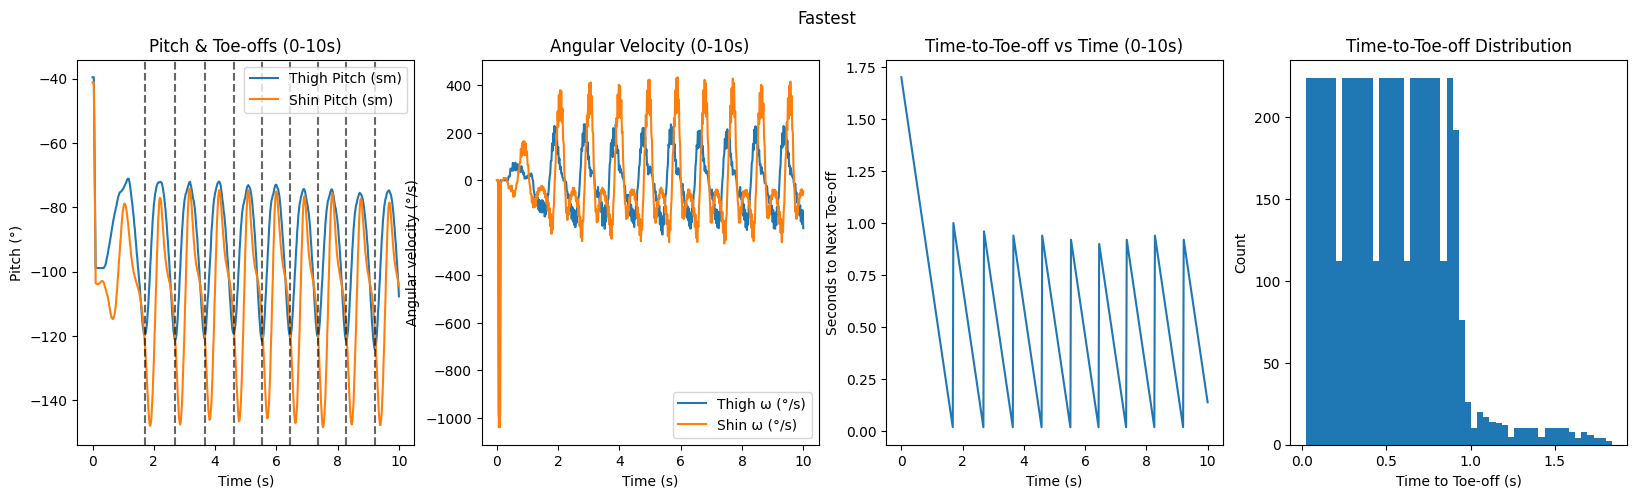

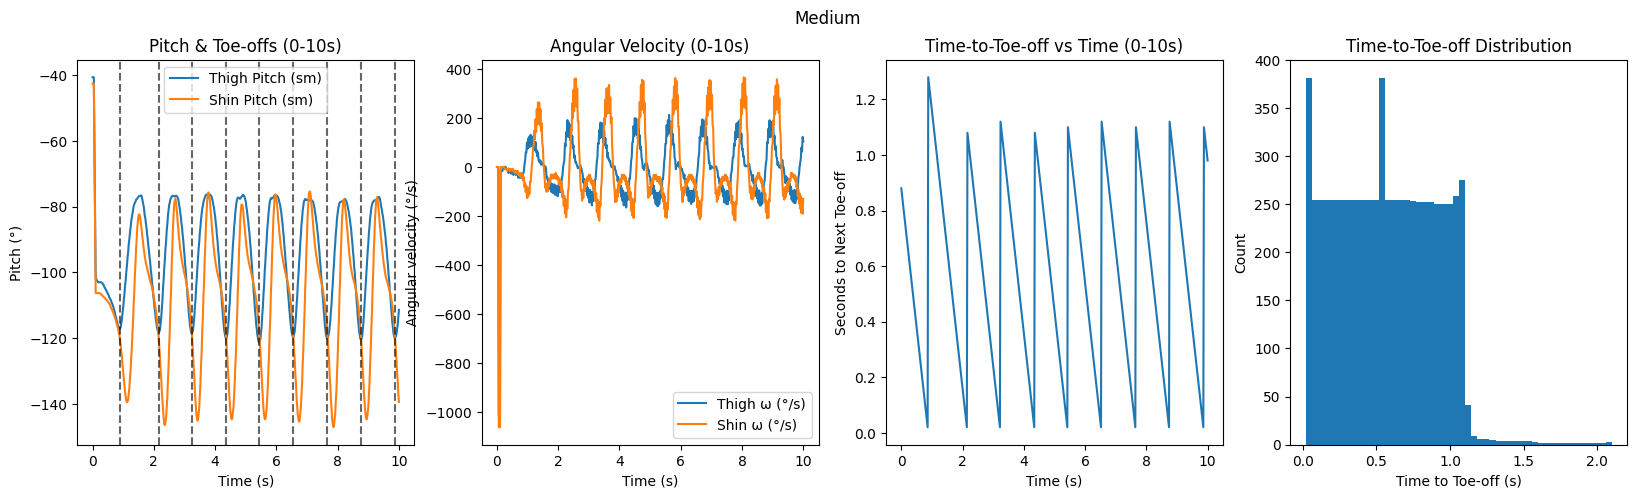

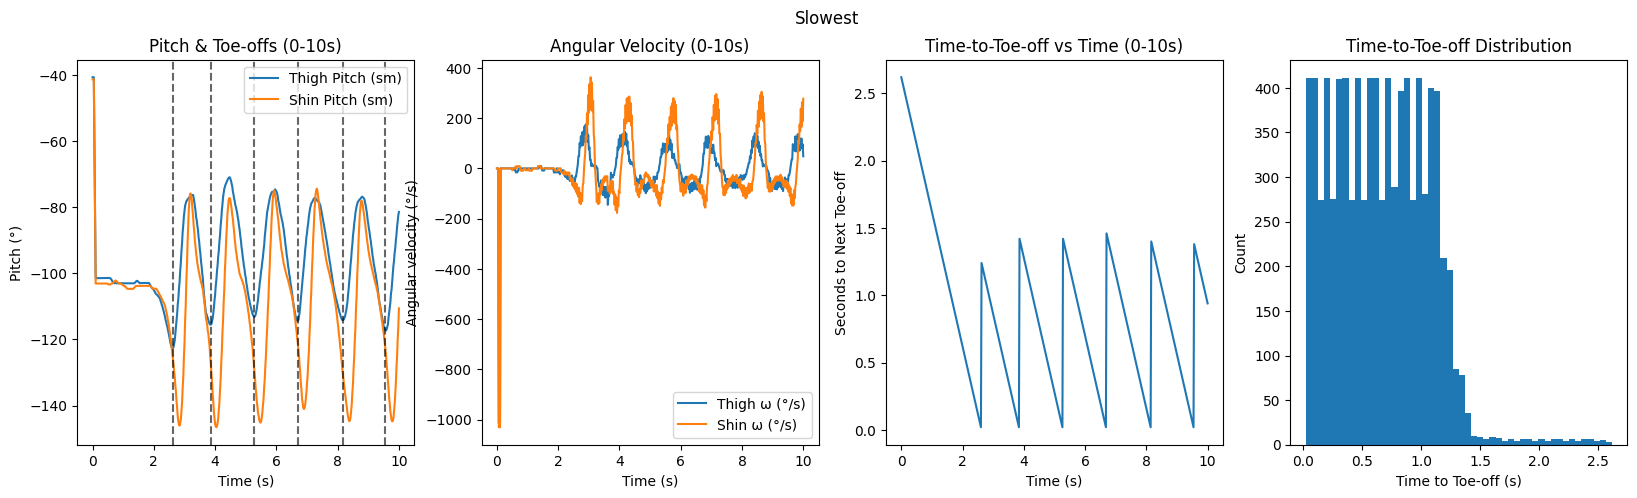

In [11]:
for i in range(3, 4):
    X_all_temp = []
    y_all_temp = []

    for name, path in DATA_FILES.items():
        df    = load_imu_data(path)
        df2   = detect_and_plot_toeoffs(df, title_prefix=name.capitalize())
        if i == 0:
            X, y  = make_dataset_thigh(df2)
            fname = "Thigh"
        elif i == 1:
            X, y = make_dataset_thigh_quats(df2)
            fname = "ThighQuats"
        elif i == 2:
            X, y = make_dataset_thigh_quats_gyros(df2)
            fname = "ThighQuatsGyros"
        else:
            X, y = make_dataset_thigh_quats_accs(df2)
            fname = "ThighQuatsAccs"

        X_all_temp.append(X)
        y_all_temp.append(y)

    X_all = np.concatenate([X_all_temp[i] for i in range(len(X_all_temp))], axis=0)
    y_all = np.concatenate([y_all_temp[i] for i in range(len(y_all_temp))], axis=0)

    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2)
    y_train_all = y_train_all.reshape(y_train_all.shape[0], -1)
    y_test_all = y_test_all.reshape(y_test_all.shape[0], -1)

    input_shape = (WINDOW_SZ, X_train_all.shape[2])

    RNN_datasets   = {}
    RNN_histories  = {}
    RNN_metrics    = {}

    GRU_datasets   = {}
    GRU_histories  = {}
    GRU_metrics    = {}

    loss = 'mse'
    metrics = ['mae']
    optimizer = 'adam'

    combined_model   = RNN_make_model(input_shape, loss, metrics, optimizer)
    combined_history = combined_model.fit(X_train_all, y_train_all,
                                          validation_data=(X_test_all, y_test_all),
                                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    loss_c, mae_c = combined_model.evaluate(X_test_all, y_test_all, verbose=0)
    print(f"Combined val MAE = {mae_c:.3f} for RNN")

    RNN_datasets["combined"]   = (X_train_all, y_train_all, X_test_all, y_test_all, combined_model)
    RNN_histories["combined"]  = combined_history
    RNN_metrics["combined"]    = mae_c

    history_rnn = RNN_histories["combined"]
    y_pred_rnn = combined_model.predict(X_test_all).flatten()

    np.savez(f"{fname}_RNN_history.npz", history=np.array([{'val_loss': history_rnn.history['val_loss'], 'val_mae': history_rnn.history['val_mae'], 'pred': (y_test_all, y_pred_rnn)}]))

    fn = f"RNN_{fname}.keras"
    combined_model.save(fn)
    print(f"Saved {fn}")

    loss = 'mse'
    metrics = ['mae']
    optimizer = 'adam'

    combined_model   = GRU_make_model(input_shape, loss, metrics, optimizer)
    combined_history = combined_model.fit(X_train_all, y_train_all,
                                          validation_data=(X_test_all, y_test_all),
                                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    loss_c, mae_c = combined_model.evaluate(X_test_all, y_test_all, verbose=0)
    print(f"Combined val MAE = {mae_c:.3f} for GRU")

    GRU_datasets["combined"]   = (X_train_all, y_train_all, X_test_all, y_test_all, combined_model)
    GRU_histories["combined"]  = combined_history
    GRU_metrics["combined"]    = mae_c

    history_gru = GRU_histories["combined"]
    y_pred_gru = combined_model.predict(X_test_all).flatten()

    np.savez(f"{fname}_GRU_history.npz", history=np.array([{'val_loss': history_gru.history['val_loss'], 'val_mae': history_gru.history['val_mae'], 'pred': (y_test_all, y_pred_gru)}]))

    fn = f"GRU_{fname}.keras"
    combined_model.save(fn)
    print(f"Saved {fn}")


131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


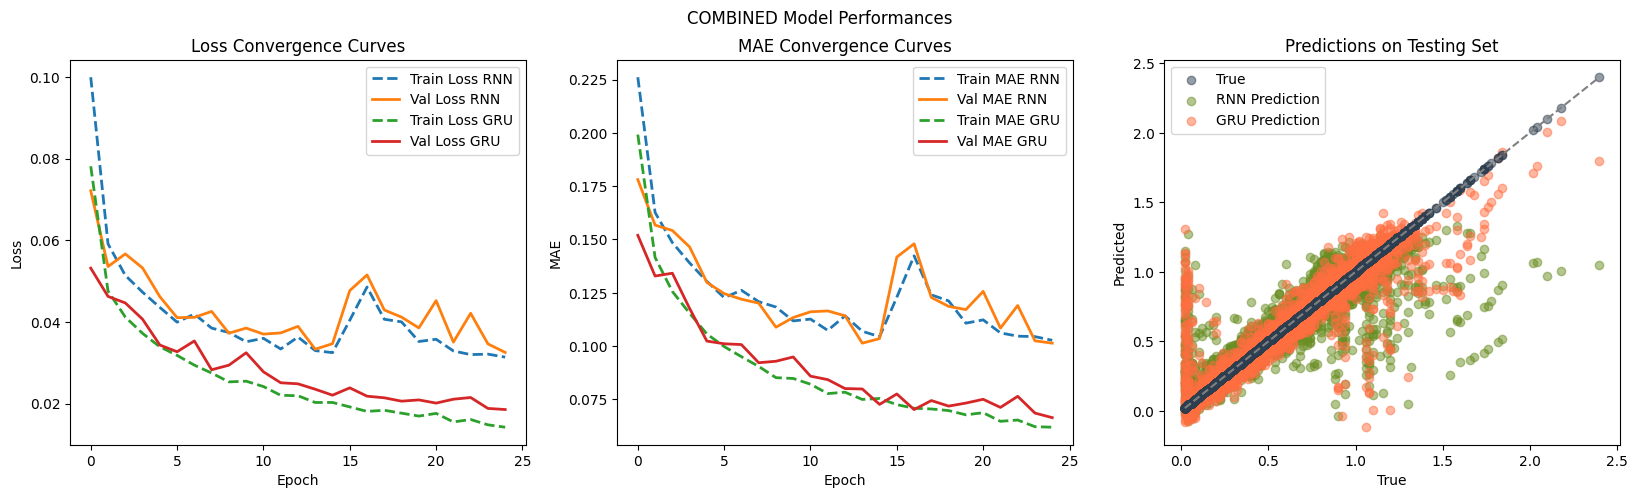

In [12]:
for name in list(RNN_histories.keys()):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"{name.upper()} Model Performances")

    X_test, y_test, model = RNN_datasets[name][2], RNN_datasets[name][3], RNN_datasets[name][4]
    history_rnn = RNN_histories[name]
    y_pred_rnn = model.predict(X_test).flatten()

    X_test, y_test, model = GRU_datasets[name][2], GRU_datasets[name][3], GRU_datasets[name][4]
    history_gru = GRU_histories[name]
    y_pred_gru = model.predict(X_test).flatten()

    ax[0].plot(history_rnn.history['loss'], '--', lw = 2, label='Train Loss RNN')
    ax[0].plot(history_rnn.history['val_loss'], lw = 2, label='Val Loss RNN')
    ax[0].plot(history_gru.history['loss'], '--', lw = 2, label='Train Loss GRU')
    ax[0].plot(history_gru.history['val_loss'], lw = 2, label='Val Loss GRU')
    ax[0].set_title("Loss Convergence Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(history_rnn.history['mae'], '--', lw = 2, label='Train MAE RNN')
    ax[1].plot(history_rnn.history['val_mae'], lw = 2, label='Val MAE RNN')
    ax[1].plot(history_gru.history['mae'], '--', lw = 2, label='Train MAE GRU')
    ax[1].plot(history_gru.history['val_mae'], lw = 2, label='Val MAE GRU')
    ax[1].set_title(f"MAE Convergence Curves")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("MAE")
    ax[1].legend()

    ax[2].scatter(y_test, y_test, alpha=0.5, color='#2C3E50', label='True', zorder=2)
    ax[2].scatter(y_test, y_pred_rnn, alpha=0.5, color='#6B8E23', label='RNN Prediction', zorder=0)
    ax[2].scatter(y_test, y_pred_gru, alpha=0.5, color='#FF6E40', label='GRU Prediction', zorder=1)
    ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
    ax[2].set_title(f"Predictions on Testing Set")
    ax[2].set_xlabel("True")
    ax[2].set_ylabel("Predicted")
    ax[2].legend()

    np.savez(f"PCA_10_RNN_history.npz", history=np.array([{'val_loss': history_rnn.history['val_loss'], 'val_mae': history_rnn.history['val_mae'], 'pred': (y_test, y_pred_rnn)}]))
    np.savez(f"PCA_10_GRU_history.npz", history=np.array([{'val_loss': history_gru.history['val_loss'], 'val_mae': history_gru.history['val_mae'], 'pred': (y_test, y_pred_gru)}]))

plt.show()

In [ ]:
keys = list(RNN_metrics.keys())
x_axis = np.arange(len(keys))

rnn_vals = [RNN_metrics[k] for k in keys]
gru_vals = [GRU_metrics[k] for k in keys]

y_axis = {'RNN': rnn_vals, 'GRU': gru_vals}

bar_width = 0.25
multiplier = 0

plt.figure(figsize=(10, 5))
ax = plt.axes()

for algo, mae in y_axis.items():
    offset = bar_width * multiplier
    rects = ax.bar(x_axis + offset, np.round(mae, 4), bar_width, label=algo)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.set_ylabel('MAE')
ax.set_title('Validation MAEs for both models on all datasets')
ax.set_xticks(x_axis + bar_width, keys)
ax.legend(loc='upper right')

plt.show()

In [ ]:
for name in list(RNN_datasets.keys()):
  fn = f"RNN_{name}_PCA10.keras"
  model = RNN_datasets[name][-1]
  model.save(fn)
  print(f"Saved {name} to {fn}")

  fn = f"GRU_{name}_PCA10.keras"
  model = GRU_datasets[name][-1]
  model.save(fn)
  print(f"Saved {name} to {fn}")